In [1]:
from os.path import expanduser
home = expanduser("~/")

import sys
# sys.path.insert(0, '/global/u2/x/xshuang/gigalens-xh-dev/src')
sbalta01_dev = False

if sbalta01_dev:
    sys.path.insert(0, home+'/gigalens-sbalta01-dev'+'/src')
    print('DEVELOPER MODE')

else:
    sys.path.insert(0, home+'/gigalens'+'/src')
    print('MASTER BRANCH GIGALENS')


import jax
print(jax.devices())


MASTER BRANCH GIGALENS
[StreamExecutorGpuDevice(id=0, process_index=0, slice_index=0)]


In [2]:
from gigalens.jax.inference import ModellingSequence
from gigalens.jax.model import ForwardProbModel, BackwardProbModel
from gigalens.model import PhysicalModel
from gigalens.jax.simulator import LensSimulator
from gigalens.simulator import SimulatorConfig
from gigalens.jax.profiles.light import sersic, shapelets
from gigalens.jax.profiles.mass import epl, shear
import lenstronomy
from lenstronomy.LensModel.lens_model import LensModel
from lenstronomy.Plots import lens_plot

import tensorflow_probability.substrates.jax as tfp
import jax
from jax import random
import numpy as np
import optax
from jax import numpy as jnp
from matplotlib import pyplot as plt
import optax
import os

srcdir = "/global/homes/l/linusu/gigalens/src/"

tfd = tfp.distributions

/global/common/software/deepsrch/jax_gigalens_kernel/jax-gigalens/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
jax.devices()

[StreamExecutorGpuDevice(id=0, process_index=0, slice_index=0)]

In [4]:
kernel = np.load(os.path.join(srcdir, 'gigalens/assets/psf.npy')).astype(np.float32)

In [5]:
phys_model = PhysicalModel([epl.EPL(50), shear.Shear()], [sersic.SersicEllipse(use_lstsq=False)], [sersic.SersicEllipse(use_lstsq=False)])
sim_config = SimulatorConfig(delta_pix=0.065, num_pix=60, supersample=1, kernel=kernel)
lens_sim = LensSimulator(phys_model, sim_config, bs=4)

In [6]:
params = ([
    {'theta_E': np.array([1.73, 1.35, 1.32, 1.51]), 
     'gamma': np.array([2.5, 2.21, 1.8, 2.34]), 
     'e1': np.array([0, 0, 0.127, 0.05]), 
     'e2': np.array([0.169, 0.1, 0.058, 0.05]), 
     'center_x': np.array([0, 0, 0, 0]), 
     'center_y': np.array([0, 0, 0, 0])},
    {'gamma1': np.array([0, 0.07, 0.02, 0.071]), 
     'gamma2': np.array([0.16, 0, 0.00, 0.071])}
    
], [{'R_sersic': np.array([0.91, 2, 1.5, 1.5]), 
     'n_sersic': np.array([1.5, 3, 4, 4]), 
     'e1': np.array([0, 0, 0.05, 0.05]), 
     'e2': np.array([0.169, 0.1, 0.05, 0.05]), 
     'center_x': np.array([0, 0, 0, 0]), 
     'center_y': np.array([0, 0, 0, 0]), 
     'Ie': np.array([29.9, 40, 50, 20])}], 
    
    [{'R_sersic': np.array([0.1, 0.1, 0.2, 0.15]), 
      'n_sersic': np.array([1.5, 1.5, 1, 1]), 
      'e1': np.array([0.1, 0, 0., 0.3]), 
      'e2': np.array([0, 0, 0.1, 0.3]), 
      'center_x': np.array([-0.16, 0.08, 0.01, 0.2]), 
      'center_y': np.array([0, 0.22, -0.01, -0.2]), 
      'Ie': np.array([120.142, 700, 550, 550])}])

In [7]:
lens_model_list = ['EPL', 'SHEAR']
kwargs_lens = [
    {'theta_E': 1.5, 
     'gamma': 2.0, # isothermal -> 2.0 ; virile theorem - > for particles to satisfy, mass slope goes as the radius ^ -2 (works for most galaxies, approximately)
     # narayan and bartelmann lecture notes (1996)
     
     'e1': 0.1, 
     'e2': 0.1, 
     'center_x': 0, 
     'center_y': 0},
    {'gamma1': 0, 
     'gamma2': 0}]
lens_model = LensModel(lens_model_list=lens_model_list)
num_pix = 60 * 4 
delta_pix = 0.065 / 4
x_grid, y_grid = np.meshgrid(
    np.linspace(-num_pix * delta_pix / 2, num_pix * delta_pix / 2, num_pix),
    np.linspace(-num_pix * delta_pix / 2, num_pix * delta_pix / 2, num_pix)
)
f_x, f_y = lens_model.alpha(x_grid, y_grid, kwargs_lens)
g_1, g_2 = lens_model.gamma(x_grid, y_grid, kwargs_lens)
kappa = lens_model.kappa(x_grid, y_grid, kwargs_lens)

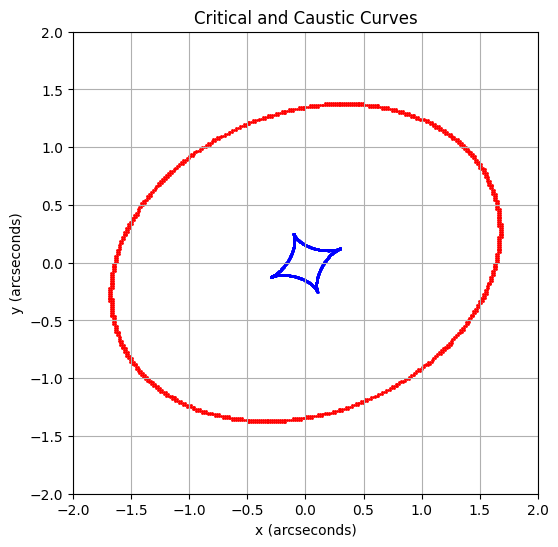

In [8]:
# Calculate magnification and critical curves
det_A = (1 - kappa)**2 - (g_1**2 + g_2**2)
critical_curve = np.abs(det_A) < 1e-2 # make det very small (1e-3) (should be 0)
# lenstronomy has a way of showing where critical curve is
# specify circular lens model, plot how magnification changes from lens center to critical curve, out to some large radius, 
# magnification curve should diverge (einstein radius)
# gamma <2 , =2, >2 (should see magnification blows up to infty at 2 location) -> look at https://arxiv.org/pdf/1904.08400
# Calculate caustics by mapping critical curves back to source plane 
x_source, y_source = lens_model.ray_shooting(x_grid[critical_curve], y_grid[critical_curve], kwargs_lens)

plt.figure(figsize=(6, 6))

# Plot critical curve in the image plane
plt.scatter(x_grid[critical_curve], y_grid[critical_curve], color='red', s=1, label='Critical Curve')

# Plot caustic curve in the source plane
plt.scatter(x_source, y_source, color='blue', s=1, label='Caustic Curve')

plt.xlabel('x (arcseconds)')
plt.ylabel('y (arcseconds)')
#plt.legend()
plt.title('Critical and Caustic Curves')
plt.xlim(-2, 2)
plt.ylim(-2, 2)
plt.grid()
plt.show()

In [9]:
lens_model_list = ['EPL', 'SHEAR']
kwargs_lens = [
    {'theta_E': 1.5, 
     'gamma': 2.0, # isothermal -> 2.0 ; virile theorem - > for particles to satisfy, mass slope goes as the radius ^ -2 (works for most galaxies, approximately)
     # narayan and bartelmann lecture notes (1996)
     
     'e1': 0.1, 
     'e2': 0.1, 
     'center_x': 0, 
     'center_y': 0},
    {'gamma1': 0, 
     'gamma2': 0}]
lens_model = LensModel(lens_model_list=lens_model_list)
num_pix = 60 * 4 
delta_pix = 0.065 / 4
x_grid, y_grid = np.meshgrid(
    np.linspace(-num_pix * delta_pix / 2, num_pix * delta_pix / 2, num_pix),
    np.linspace(-num_pix * delta_pix / 2, num_pix * delta_pix / 2, num_pix)
)
f_x, f_y = lens_model.alpha(x_grid, y_grid, kwargs_lens)
g_1, g_2 = lens_model.gamma(x_grid, y_grid, kwargs_lens)
kappa = lens_model.kappa(x_grid, y_grid, kwargs_lens)

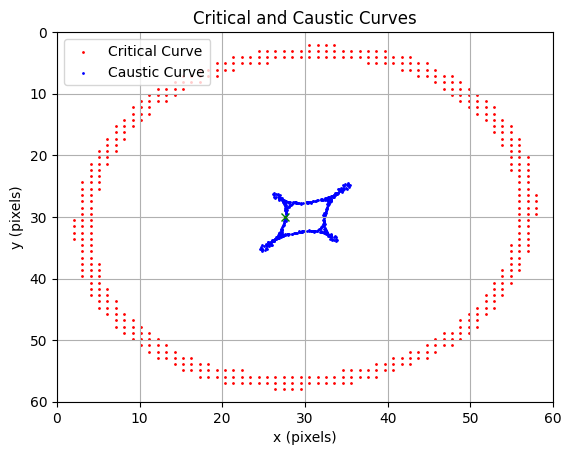

In [10]:
kwargs_lens = [{'theta_E': 1.73, 
     'gamma': 2.50,
     'e1': 0, 
     'e2': 0.169, 
     'center_x': 0, 
     'center_y': 0},
    {'gamma1': 0,  
     'gamma2': 0.16}]
lens_model = LensModel(lens_model_list=lens_model_list)
num_pix = 60
delta_pix = 0.065
x_grid, y_grid = np.meshgrid(
    np.linspace(-num_pix * delta_pix / 2, num_pix * delta_pix / 2, num_pix),
    np.linspace(-num_pix * delta_pix / 2, num_pix * delta_pix / 2, num_pix)
)
f_x, f_y = lens_model.alpha(x_grid, y_grid, kwargs_lens)
g_1, g_2 = lens_model.gamma(x_grid, y_grid, kwargs_lens)
kappa = lens_model.kappa(x_grid, y_grid, kwargs_lens)

# Calculate magnification and critical curves
det_A = (1 - kappa)**2 - (g_1**2 + g_2**2)
critical_curve = np.abs(det_A) < 1e-1

# Calculate caustics by mapping critical curves back to source plane
x_source, y_source = lens_model.ray_shooting(x_grid[critical_curve], y_grid[critical_curve], kwargs_lens)

x_grid_scaled, y_grid_scaled = np.meshgrid(
    np.linspace(0, 60, 60),
    np.linspace(0, 60, 60)
)

plt.scatter(x_grid_scaled[critical_curve], y_grid_scaled[critical_curve], color='red', s=1, label='Critical Curve')

x_source_scaled = [(i + 2) * 15 for i in x_source]
y_source_scaled = [(i + 2) * 15 for i in y_source]
# Plot caustic curve in the source plane
plt.scatter(x_source_scaled, y_source_scaled, color='blue', s=1, label='Caustic Curve')

plt.xlabel('x (pixels)')
plt.ylabel('y (pixels)')
plt.legend()
plt.title('Critical and Caustic Curves')
plt.xlim(0, 60)
plt.ylim(0, 60)
plt.plot(-0.16 / 0.065 + 30, 0 / 0.065 + 30,'gx') 
plt.gca().invert_yaxis()
plt.grid()
plt.show()

In [11]:
mag_grid = 1/det_A

In [12]:
mag_grid

array([[1.54871275, 1.5782527 , 1.61024919, ..., 1.87980611, 1.83160278,
        1.78712599],
       [1.5782527 , 1.61135171, 1.64744284, ..., 1.93741799, 1.88215205,
        1.83160278],
       [1.61024919, 1.64744284, 1.68829542, ..., 2.00101022, 1.93741799,
        1.87980611],
       ...,
       [1.87980611, 1.93741799, 2.00101022, ..., 1.68829542, 1.64744284,
        1.61024919],
       [1.83160278, 1.88215205, 1.93741799, ..., 1.64744284, 1.61135171,
        1.5782527 ],
       [1.78712599, 1.83160278, 1.87980611, ..., 1.61024919, 1.5782527 ,
        1.54871275]])

In [13]:
sim_lenses = lens_sim.simulate(params)

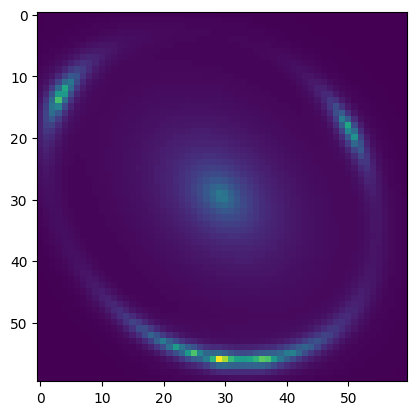

In [14]:
#plt.scatter(x_grid_scaled[critical_curve], y_grid_scaled[critical_curve], color='red', s=1, label='Critical Curve')
#plt.scatter(x_source_scaled, y_source_scaled, color='green', s=1, label='Caustic Curve')
#plt.plot(-0.3 / 0.065 + 30, 0 / 0.065 + 30,'rv') 
plt.imshow(sim_lenses[0])

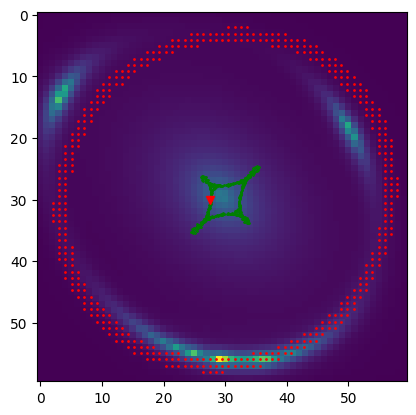

In [15]:
plt.scatter(x_grid_scaled[critical_curve], y_grid_scaled[critical_curve], color='red', s=1, label='Critical Curve')
plt.scatter(x_source_scaled, y_source_scaled, color='green', s=1, label='Caustic Curve')
plt.plot(-0.16 / 0.065 + 30, 0 / 0.065 + 30,'rv') 
plt.imshow(sim_lenses[0])

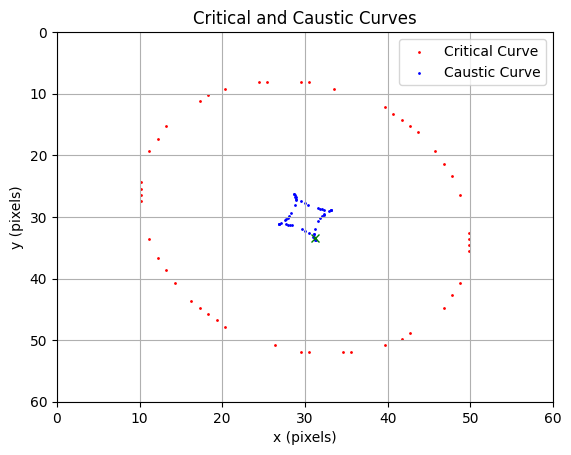

In [16]:
kwargs_lens = [{'theta_E': 1.35, 
     'gamma': 2.21, 
     'e1': 0, 
     'e2': 0.1, 
     'center_x': 0, 
     'center_y': 0},
    {'gamma1': 0.07,  
     'gamma2': 0}]
lens_model = LensModel(lens_model_list=lens_model_list)
num_pix = 60
delta_pix = 0.065
x_grid, y_grid = np.meshgrid(
    np.linspace(-num_pix * delta_pix / 2, num_pix * delta_pix / 2, num_pix),
    np.linspace(-num_pix * delta_pix / 2, num_pix * delta_pix / 2, num_pix)
)
f_x, f_y = lens_model.alpha(x_grid, y_grid, kwargs_lens)
g_1, g_2 = lens_model.gamma(x_grid, y_grid, kwargs_lens)
kappa = lens_model.kappa(x_grid, y_grid, kwargs_lens)

# Calculate magnification and critical curves
det_A = (1 - kappa)**2 - (g_1**2 + g_2**2)
critical_curve = np.abs(det_A) < 1e-2

# Calculate caustics by mapping critical curves back to source plane
x_source, y_source = lens_model.ray_shooting(x_grid[critical_curve], y_grid[critical_curve], kwargs_lens)

x_grid_scaled, y_grid_scaled = np.meshgrid(
    np.linspace(0, 60, 60),
    np.linspace(0, 60, 60)
)

plt.scatter(x_grid_scaled[critical_curve], y_grid_scaled[critical_curve], color='red', s=1, label='Critical Curve')

x_source_scaled = [(i + 2) * 15 for i in x_source]
y_source_scaled = [(i + 2) * 15 for i in y_source]
# Plot caustic curve in the source plane
plt.scatter(x_source_scaled, y_source_scaled, color='blue', s=1, label='Caustic Curve')

plt.xlabel('x (pixels)')
plt.ylabel('y (pixels)')
plt.legend()
plt.title('Critical and Caustic Curves')
plt.xlim(0, 60)
plt.ylim(0, 60)
plt.plot(0.08 / 0.065 + 30, 0.22 / 0.065 + 30,'gx') 
plt.gca().invert_yaxis()
plt.grid()
plt.show()

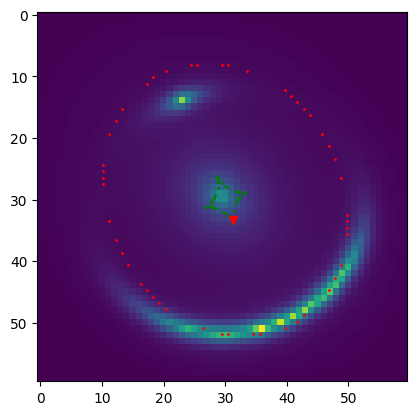

In [17]:
plt.scatter(x_grid_scaled[critical_curve], y_grid_scaled[critical_curve], color='red', s=1, label='Critical Curve')
plt.scatter(x_source_scaled, y_source_scaled, color='green', s=1, label='Caustic Curve')
plt.plot(0.08 / 0.065 + 30, 0.22 / 0.065 + 30,'rv') 
plt.imshow(sim_lenses[1])

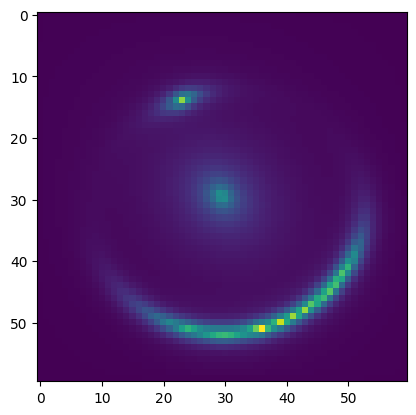

In [18]:
plt.imshow(sim_lenses[1])

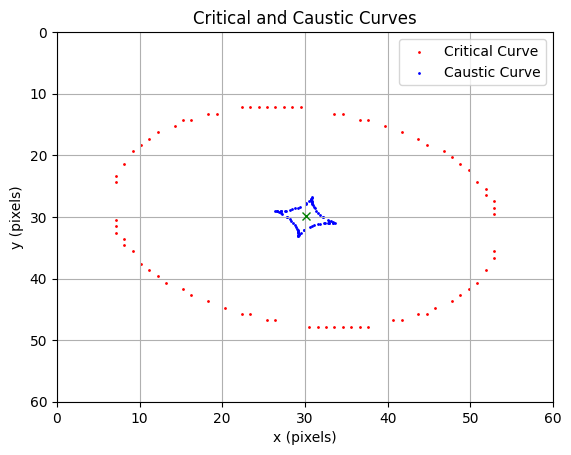

In [19]:
kwargs_lens = [ {'theta_E': 1.32, 
     'gamma': 1.8, 
     'e1': 0.127, 
     'e2': 0.058, 
     'center_x': 0, 
     'center_y': 0},
    {'gamma1': 0.02, 
     'gamma2': 0.00}]
lens_model = LensModel(lens_model_list=lens_model_list)
num_pix = 60
delta_pix = 0.065
x_grid, y_grid = np.meshgrid(
    np.linspace(-num_pix * delta_pix / 2, num_pix * delta_pix / 2, num_pix),
    np.linspace(-num_pix * delta_pix / 2, num_pix * delta_pix / 2, num_pix)
)
f_x, f_y = lens_model.alpha(x_grid, y_grid, kwargs_lens)
g_1, g_2 = lens_model.gamma(x_grid, y_grid, kwargs_lens)
kappa = lens_model.kappa(x_grid, y_grid, kwargs_lens)

# Calculate magnification and critical curves
det_A = (1 - kappa)**2 - (g_1**2 + g_2**2)
critical_curve = np.abs(det_A) < 1e-2

# Calculate caustics by mapping critical curves back to source plane
x_source, y_source = lens_model.ray_shooting(x_grid[critical_curve], y_grid[critical_curve], kwargs_lens)

x_grid_scaled, y_grid_scaled = np.meshgrid(
    np.linspace(0, 60, 60),
    np.linspace(0, 60, 60)
)

plt.scatter(x_grid_scaled[critical_curve], y_grid_scaled[critical_curve], color='red', s=1, label='Critical Curve')

x_source_scaled = [(i + 2) * 15 for i in x_source]
y_source_scaled = [(i + 2) * 15 for i in y_source]
# Plot caustic curve in the source plane
plt.scatter(x_source_scaled, y_source_scaled, color='blue', s=1, label='Caustic Curve')

plt.xlabel('x (pixels)')
plt.ylabel('y (pixels)')
plt.legend()
plt.title('Critical and Caustic Curves')
plt.xlim(0, 60)
plt.ylim(0, 60)
plt.plot(0.01 / 0.065 + 30, -0.01 / 0.065 + 30,'gx') 
plt.gca().invert_yaxis()
plt.grid()
plt.show()

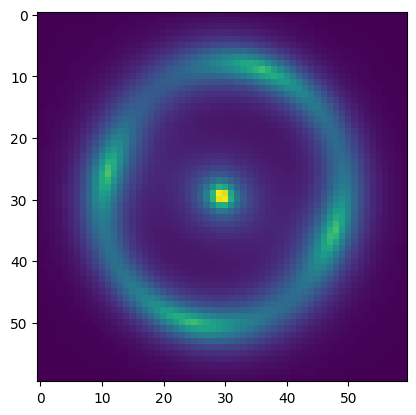

In [20]:
plt.imshow(sim_lenses[2])

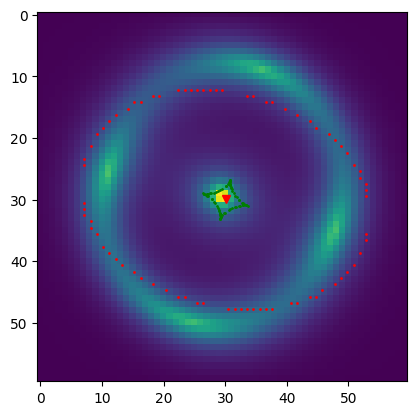

In [21]:
plt.scatter(x_grid_scaled[critical_curve], y_grid_scaled[critical_curve], color='red', s=1, label='Critical Curve')
plt.scatter(x_source_scaled, y_source_scaled, color='green', s=1, label='Caustic Curve')
plt.plot(0.01 / 0.065 + 30, -0.01 / 0.065 + 30,'rv') 
plt.imshow(sim_lenses[2])

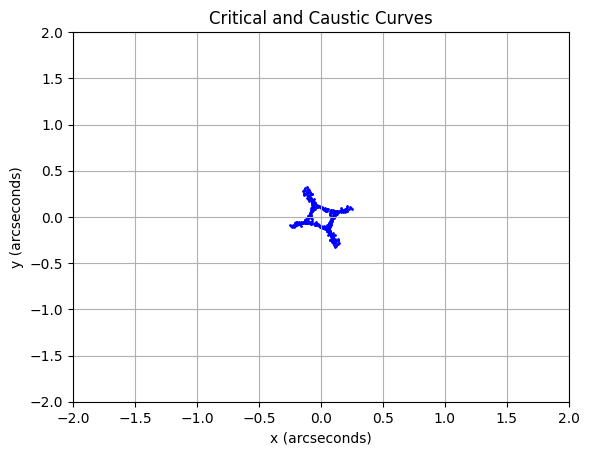

In [22]:
kwargs_lens = [{'theta_E': 1.51, 
     'gamma': 2.34, 
     'e1': 0.05, 
     'e2': 0.05, 
     'center_x': 0, 
     'center_y': 0},
    {'gamma1': 0.071, 
     'gamma2': 0.071}]
lens_model = LensModel(lens_model_list=lens_model_list)
num_pix = 60
delta_pix = 0.065
x_grid, y_grid = np.meshgrid(
    np.linspace(-num_pix * delta_pix / 2, num_pix * delta_pix / 2, num_pix),
    np.linspace(-num_pix * delta_pix / 2, num_pix * delta_pix / 2, num_pix)
)
f_x, f_y = lens_model.alpha(x_grid, y_grid, kwargs_lens)
g_1, g_2 = lens_model.gamma(x_grid, y_grid, kwargs_lens)
kappa = lens_model.kappa(x_grid, y_grid, kwargs_lens)

# Calculate magnification and critical curves
det_A = (1 - kappa)**2 - (g_1**2 + g_2**2)
critical_curve = np.abs(det_A) < 1e-1

# Calculate caustics by mapping critical curves back to source plane
x_source, y_source = lens_model.ray_shooting(x_grid[critical_curve], y_grid[critical_curve], kwargs_lens)

# Plot caustic curve in the source plane
plt.scatter(x_source, y_source, color='blue', s=1, label='Caustic Curve')

plt.xlabel('x (arcseconds)')
plt.ylabel('y (arcseconds)')
#plt.legend()
plt.title('Critical and Caustic Curves')
plt.xlim(-2, 2)
plt.ylim(-2, 2)
plt.grid()
plt.show()

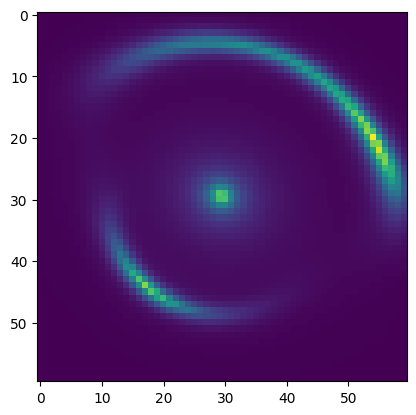

In [23]:
plt.imshow(sim_lenses[3])

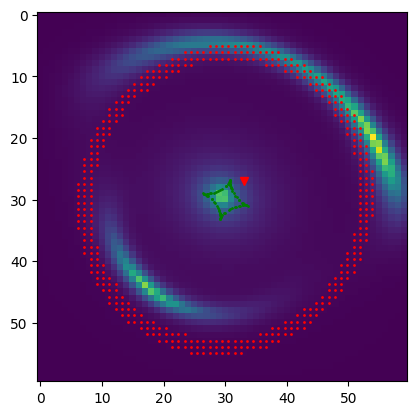

In [24]:
plt.scatter(x_grid_scaled[critical_curve], y_grid_scaled[critical_curve], color='red', s=1, label='Critical Curve')
plt.scatter(x_source_scaled, y_source_scaled, color='green', s=1, label='Caustic Curve')
plt.plot(0.2 / 0.065 + 30, -0.2 / 0.065 + 30,'rv') 
plt.imshow(sim_lenses[3])

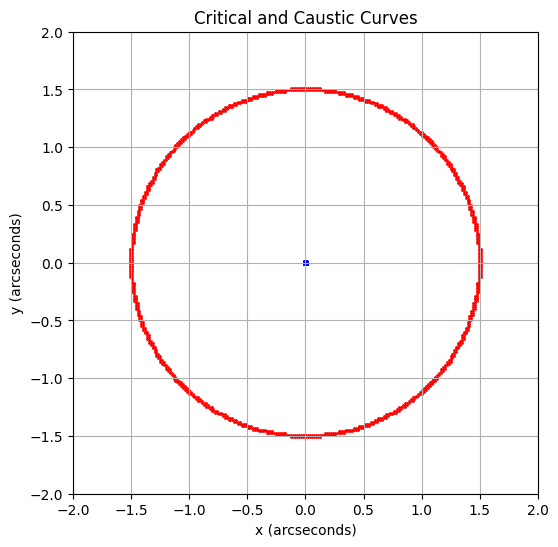

In [25]:
lens_model_list = ['EPL', 'SHEAR']
kwargs_lens = [
    {'theta_E': 1.5, 
     'gamma': 2.0, # isothermal -> 2.0 ; virile theorem - > for particles to satisfy, mass slope goes as the radius ^ -2 (works for most galaxies, approximately)
     # narayan and bartelmann lecture notes (1996)
     
     'e1': 0, 
     'e2': 0, 
     'center_x': 0, 
     'center_y': 0},
    {'gamma1': 0, 
     'gamma2': 0}]
lens_model = LensModel(lens_model_list=lens_model_list)
num_pix = 60 * 4
delta_pix = 0.065 / 4
x_grid, y_grid = np.meshgrid(
    np.linspace(-num_pix * delta_pix / 2, num_pix * delta_pix / 2, num_pix),
    np.linspace(-num_pix * delta_pix / 2, num_pix * delta_pix / 2, num_pix)
)
f_x, f_y = lens_model.alpha(x_grid, y_grid, kwargs_lens)
g_1, g_2 = lens_model.gamma(x_grid, y_grid, kwargs_lens)
kappa = lens_model.kappa(x_grid, y_grid, kwargs_lens)

# Calculate magnification and critical curves
det_A = (1 - kappa)**2 - (g_1**2 + g_2**2)
critical_curve = np.abs(det_A) < 1e-2 # make det very small (1e-3) (should be 0)
# lenstronomy has a way of showing where critical curve is
# specify circular lens model, plot how magnification changes from lens center to critical curve, out to some large radius, 
# magnification curve should diverge (einstein radius)
# gamma <2 , =2, >2 (should see magnification blows up to infty at 2 location) -> look at https://arxiv.org/pdf/1904.08400
# Calculate caustics by mapping critical curves back to source plane 
x_source, y_source = lens_model.ray_shooting(x_grid[critical_curve], y_grid[critical_curve], kwargs_lens)

plt.figure(figsize=(6, 6))

# Plot critical curve in the image plane
plt.scatter(x_grid[critical_curve], y_grid[critical_curve], color='red', s=1, label='Critical Curve')

# Plot caustic curve in the source plane
plt.scatter(x_source, y_source, color='blue', s=1, label='Caustic Curve')

plt.xlabel('x (arcseconds)')
plt.ylabel('y (arcseconds)')
#plt.legend()
plt.title('Critical and Caustic Curves')
plt.xlim(-2, 2)
plt.ylim(-2, 2)
plt.grid()
plt.show()

In [26]:
x_grid.shape

(240, 240)

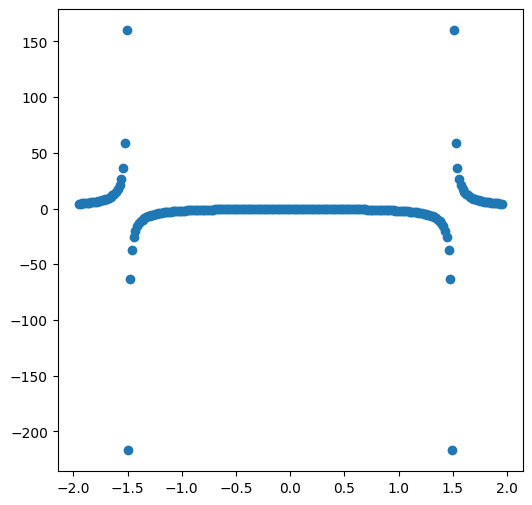

In [27]:
# plot mag vs radius (along y = 0)

plt.figure(figsize=(6, 6))
plt.scatter(x_grid[120], 1 / det_A[120])
plt.show()

<Axes: >

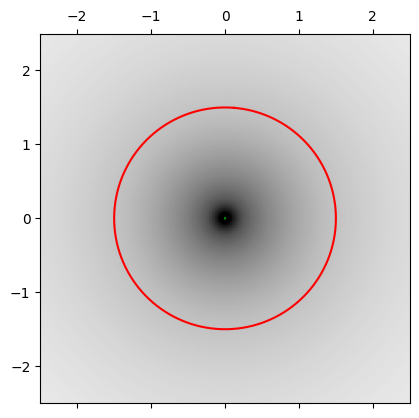

In [28]:
fig, ax = plt.subplots()
lens_plot.lens_model_plot(
    ax=ax,
    lensModel=lens_model,
    kwargs_lens=kwargs_lens,
    with_caustics=True
)

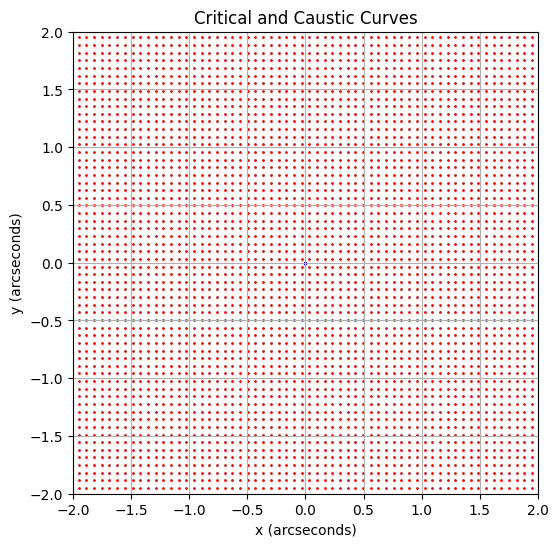

In [29]:
lens_model_list = ['EPL', 'SHEAR']
kwargs_lens = [
    {'theta_E': 1.5, 
     'gamma': 1.0, # isothermal -> 2.0 ; virile theorem - > for particles to satisfy, mass slope goes as the radius ^ -2 (works for most galaxies, approximately)
     # narayan and bartelmann lecture notes (1996)
     
     'e1': 0, 
     'e2': 0, 
     'center_x': 0, 
     'center_y': 0},
    {'gamma1': 0, 
     'gamma2': 0}]
lens_model = LensModel(lens_model_list=lens_model_list)
num_pix = 60 
delta_pix = 0.065
x_grid, y_grid = np.meshgrid(
    np.linspace(-num_pix * delta_pix / 2, num_pix * delta_pix / 2, num_pix),
    np.linspace(-num_pix * delta_pix / 2, num_pix * delta_pix / 2, num_pix)
)
f_x, f_y = lens_model.alpha(x_grid, y_grid, kwargs_lens)
g_1, g_2 = lens_model.gamma(x_grid, y_grid, kwargs_lens)
kappa = lens_model.kappa(x_grid, y_grid, kwargs_lens)

# Calculate magnification and critical curves
det_A = (1 - kappa)**2 - (g_1**2 + g_2**2)
critical_curve = np.abs(det_A) < 1e-10 # make det very small (1e-3) (should be 0)
# lenstronomy has a way of showing where critical curve is
# specify circular lens model, plot how magnification changes from lens center to critical curve, out to some large radius, 
# magnification curve should diverge (einstein radius)
# gamma <2 , =2, >2 (should see magnification blows up to infty at 2 location) -> look at https://arxiv.org/pdf/1904.08400
# Calculate caustics by mapping critical curves back to source plane 
x_source, y_source = lens_model.ray_shooting(x_grid[critical_curve], y_grid[critical_curve], kwargs_lens)

plt.figure(figsize=(6, 6))

# Plot critical curve in the image plane
plt.scatter(x_grid[critical_curve], y_grid[critical_curve], color='red', s=1, label='Critical Curve')

# Plot caustic curve in the source plane
plt.scatter(x_source, y_source, color='blue', s=1, label='Caustic Curve')

plt.xlabel('x (arcseconds)')
plt.ylabel('y (arcseconds)')
#plt.legend()
plt.title('Critical and Caustic Curves')
plt.xlim(-2, 2)
plt.ylim(-2, 2)
plt.grid()
plt.show()

In [30]:
x_grid.shape

(60, 60)

/tmp/ipykernel_902206/441134596.py:4: RuntimeWarning: divide by zero encountered in divide
  plt.scatter(x_grid[30], 1 / det_A[30])


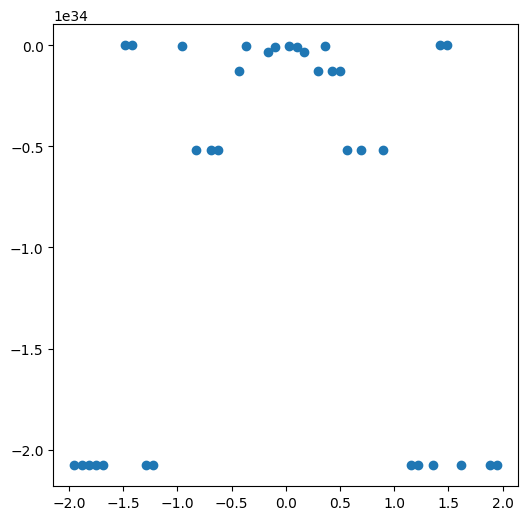

In [31]:
# plot mag vs radius (along y = 0)

plt.figure(figsize=(6, 6))
plt.scatter(x_grid[30], 1 / det_A[30])
plt.show()

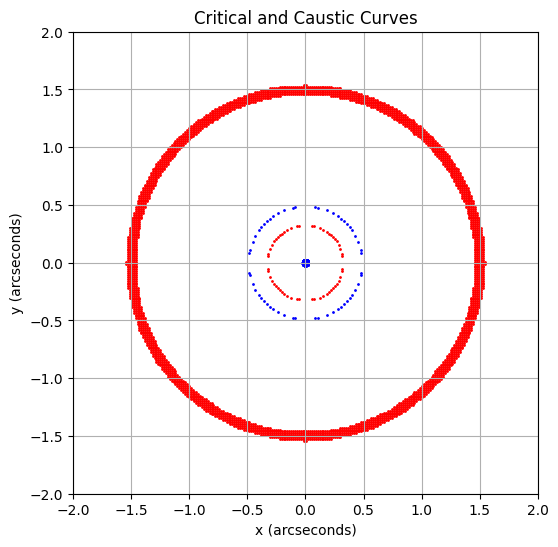

In [32]:
lens_model_list = ['EPL', 'SHEAR']
kwargs_lens = [
    {'theta_E': 1.5, 
     'gamma': 1.6, # isothermal -> 2.0 ; virile theorem - > for particles to satisfy, mass slope goes as the radius ^ -2 (works for most galaxies, approximately)
     # narayan and bartelmann lecture notes (1996)
     
     'e1': 0, 
     'e2': 0, 
     'center_x': 0, 
     'center_y': 0},
    {'gamma1': 0, 
     'gamma2': 0}]
lens_model = LensModel(lens_model_list=lens_model_list)
num_pix = 60 * 4
delta_pix = 0.065 / 4
x_grid, y_grid = np.meshgrid(
    np.linspace(-num_pix * delta_pix / 2, num_pix * delta_pix / 2, num_pix),
    np.linspace(-num_pix * delta_pix / 2, num_pix * delta_pix / 2, num_pix)
)
f_x, f_y = lens_model.alpha(x_grid, y_grid, kwargs_lens)
g_1, g_2 = lens_model.gamma(x_grid, y_grid, kwargs_lens)
kappa = lens_model.kappa(x_grid, y_grid, kwargs_lens)

# Calculate magnification and critical curves
det_A = (1 - kappa)**2 - (g_1**2 + g_2**2)
critical_curve = np.abs(det_A) < 1e-2 # make det very small (1e-3) (should be 0)
# lenstronomy has a way of showing where critical curve is
# specify circular lens model, plot how magnification changes from lens center to critical curve, out to some large radius, 
# magnification curve should diverge (einstein radius)
# gamma <2 , =2, >2 (should see magnification blows up to infty at 2 location) -> look at https://arxiv.org/pdf/1904.08400
# Calculate caustics by mapping critical curves back to source plane 
x_source, y_source = lens_model.ray_shooting(x_grid[critical_curve], y_grid[critical_curve], kwargs_lens)

plt.figure(figsize=(6, 6))

# Plot critical curve in the image plane
plt.scatter(x_grid[critical_curve], y_grid[critical_curve], color='red', s=1, label='Critical Curve')

# Plot caustic curve in the source plane
plt.scatter(x_source, y_source, color='blue', s=1, label='Caustic Curve')

plt.xlabel('x (arcseconds)')
plt.ylabel('y (arcseconds)')
#plt.legend()
plt.title('Critical and Caustic Curves')
plt.xlim(-2, 2)
plt.ylim(-2, 2)
plt.grid()
plt.show()

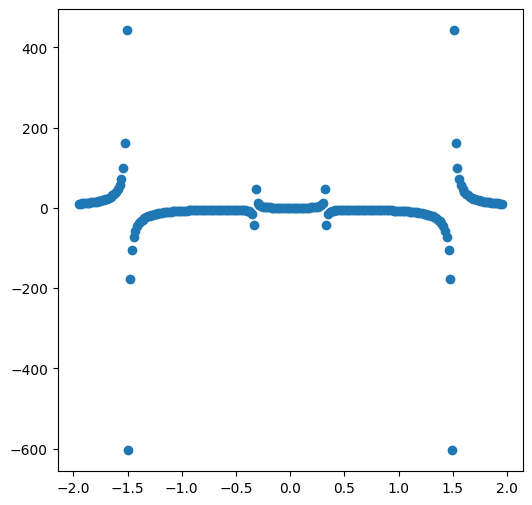

In [33]:
# plot mag vs radius (along y = 0)

plt.figure(figsize=(6, 6))
plt.scatter(x_grid[120], 1 / det_A[120])
plt.show()

<Axes: >

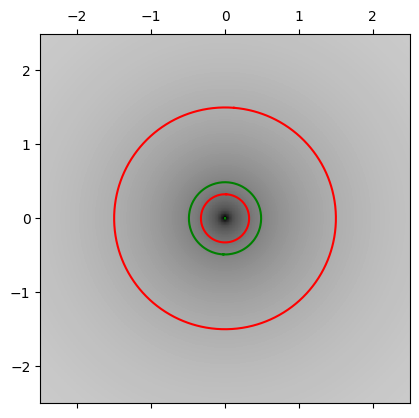

In [34]:
fig, ax = plt.subplots()
lens_plot.lens_model_plot(
    ax=ax,
    lensModel=lens_model,
    kwargs_lens=kwargs_lens,
    with_caustics=True
)

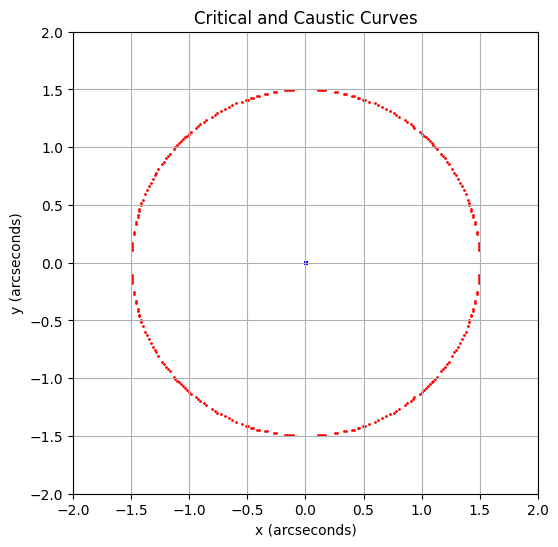

In [35]:
lens_model_list = ['EPL', 'SHEAR']
kwargs_lens = [
    {'theta_E': 1.5, 
     'gamma': 3.0, # isothermal -> 2.0 ; virile theorem - > for particles to satisfy, mass slope goes as the radius ^ -2 (works for most galaxies, approximately)
     # narayan and bartelmann lecture notes (1996)
     
     'e1': 0, 
     'e2': 0, 
     'center_x': 0, 
     'center_y': 0},
    {'gamma1': 0, 
     'gamma2': 0}]
lens_model = LensModel(lens_model_list=lens_model_list)
num_pix = 60 * 4
delta_pix = 0.065 / 4
x_grid, y_grid = np.meshgrid(
    np.linspace(-num_pix * delta_pix / 2, num_pix * delta_pix / 2, num_pix),
    np.linspace(-num_pix * delta_pix / 2, num_pix * delta_pix / 2, num_pix)
)
f_x, f_y = lens_model.alpha(x_grid, y_grid, kwargs_lens)
g_1, g_2 = lens_model.gamma(x_grid, y_grid, kwargs_lens)
kappa = lens_model.kappa(x_grid, y_grid, kwargs_lens)

# Calculate magnification and critical curves
det_A = (1 - kappa)**2 - (g_1**2 + g_2**2)
critical_curve = np.abs(det_A) < 1e-2 # make det very small (1e-3) (should be 0)
# lenstronomy has a way of showing where critical curve is
# specify circular lens model, plot how magnification changes from lens center to critical curve, out to some large radius, 
# magnification curve should diverge (einstein radius)
# gamma <2 , =2, >2 (should see magnification blows up to infty at 2 location) -> look at https://arxiv.org/pdf/1904.08400
# Calculate caustics by mapping critical curves back to source plane 
x_source, y_source = lens_model.ray_shooting(x_grid[critical_curve], y_grid[critical_curve], kwargs_lens)

plt.figure(figsize=(6, 6))

# Plot critical curve in the image plane
plt.scatter(x_grid[critical_curve], y_grid[critical_curve], color='red', s=1, label='Critical Curve')

# Plot caustic curve in the source plane
plt.scatter(x_source, y_source, color='blue', s=1, label='Caustic Curve')

plt.xlabel('x (arcseconds)')
plt.ylabel('y (arcseconds)')
#plt.legend()
plt.title('Critical and Caustic Curves')
plt.xlim(-2, 2)
plt.ylim(-2, 2)
plt.grid()
plt.show()

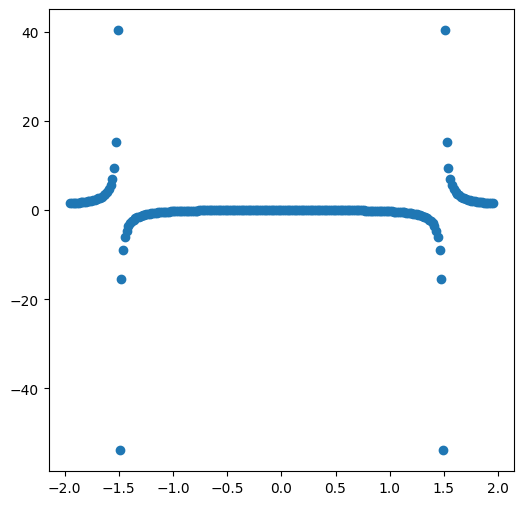

In [36]:
# plot mag vs radius (along y = 0)

plt.figure(figsize=(6, 6))
plt.scatter(x_grid[120], 1 / det_A[120])
plt.show()

/global/common/software/deepsrch/jax_gigalens_kernel/jax-gigalens/lib/python3.11/site-packages/lenstronomy/Plots/lens_plot.py:162: RuntimeWarning: divide by zero encountered in log10
  np.log10(kappa_result),


<Axes: >

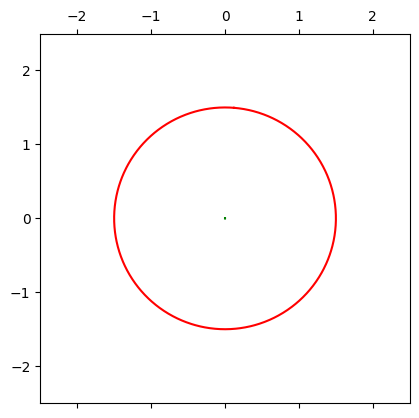

In [37]:
fig, ax = plt.subplots()
lens_plot.lens_model_plot(
    ax=ax,
    lensModel=lens_model,
    kwargs_lens=kwargs_lens,
    with_caustics=True
)

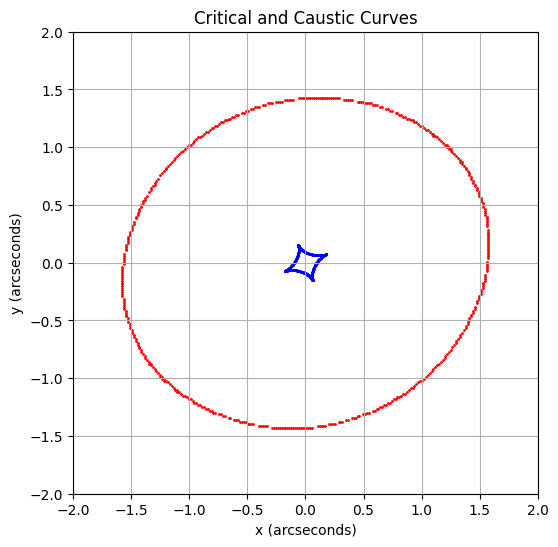

In [38]:
lens_model_list = ['EPL', 'SHEAR']
kwargs_lens = [
    {'theta_E': 1.5, 
     'gamma': 2.5, # isothermal -> 2.0 ; virile theorem - > for particles to satisfy, mass slope goes as the radius ^ -2 (works for most galaxies, approximately)
     # narayan and bartelmann lecture notes (1996)
     
     'e1': 0.1, 
     'e2': 0.1, 
     'center_x': 0, 
     'center_y': 0},
    {'gamma1': 0, 
     'gamma2': 0}]
lens_model = LensModel(lens_model_list=lens_model_list)
num_pix = 60 * 4
delta_pix = 0.065 / 4
x_grid, y_grid = np.meshgrid(
    np.linspace(-num_pix * delta_pix / 2, num_pix * delta_pix / 2, num_pix),
    np.linspace(-num_pix * delta_pix / 2, num_pix * delta_pix / 2, num_pix)
)
f_x, f_y = lens_model.alpha(x_grid, y_grid, kwargs_lens)
g_1, g_2 = lens_model.gamma(x_grid, y_grid, kwargs_lens)
kappa = lens_model.kappa(x_grid, y_grid, kwargs_lens)

# Calculate magnification and critical curves
det_A = (1 - kappa)**2 - (g_1**2 + g_2**2)
critical_curve = np.abs(det_A) < 1e-2 # make det very small (1e-3) (should be 0)
# lenstronomy has a way of showing where critical curve is
# specify circular lens model, plot how magnification changes from lens center to critical curve, out to some large radius, 
# magnification curve should diverge (einstein radius)
# gamma <2 , =2, >2 (should see magnification blows up to infty at 2 location) -> look at https://arxiv.org/pdf/1904.08400
# Calculate caustics by mapping critical curves back to source plane 
x_source, y_source = lens_model.ray_shooting(x_grid[critical_curve], y_grid[critical_curve], kwargs_lens)

plt.figure(figsize=(6, 6))

# Plot critical curve in the image plane
plt.scatter(x_grid[critical_curve], y_grid[critical_curve], color='red', s=1, label='Critical Curve')

# Plot caustic curve in the source plane
plt.scatter(x_source, y_source, color='blue', s=1, label='Caustic Curve')

plt.xlabel('x (arcseconds)')
plt.ylabel('y (arcseconds)')
#plt.legend()
plt.title('Critical and Caustic Curves')
plt.xlim(-2, 2)
plt.ylim(-2, 2)
plt.grid()
plt.show()

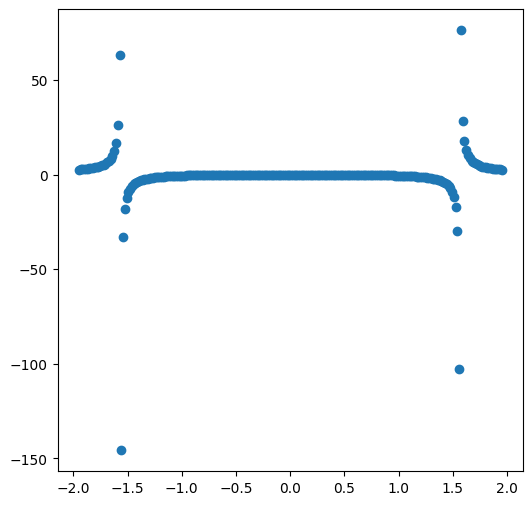

In [39]:
# plot mag vs radius (along y = 0)

plt.figure(figsize=(6, 6))
plt.scatter(x_grid[120], 1 / det_A[120])
plt.show()

In [40]:
from lenstronomy.Plots import lens_plot

<Axes: >

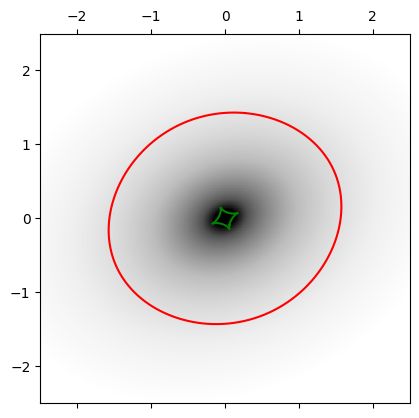

In [41]:
fig, ax = plt.subplots()
lens_plot.lens_model_plot(
    ax=ax,
    lensModel=lens_model,
    kwargs_lens=kwargs_lens,
    with_caustics=True
)

In [42]:
lens_prior = tfd.JointDistributionSequential(
    [
        tfd.JointDistributionNamed(
            dict(
                theta_E=tfd.LogNormal(jnp.log(1.25), 0.25),
                gamma=tfd.TruncatedNormal(2, 0.25, 1, 3),
                e1=tfd.Normal(0, 0.1),
                e2=tfd.Normal(0, 0.1),
                center_x=tfd.Normal(0, 0.05),
                center_y=tfd.Normal(0, 0.05),
            )
        ),
        tfd.JointDistributionNamed(
            dict(gamma1=tfd.Normal(0, 0.05), gamma2=tfd.Normal(0, 0.05))
        ),
    ]
)
lens_light_prior = tfd.JointDistributionSequential(
    [
        tfd.JointDistributionNamed(
            dict(
                R_sersic=tfd.LogNormal(jnp.log(1.0), 0.15),
                n_sersic=tfd.Uniform(2, 6),
                e1=tfd.TruncatedNormal(0, 0.1, -0.3, 0.3),
                e2=tfd.TruncatedNormal(0, 0.1, -0.3, 0.3),
                center_x=tfd.Normal(0, 0.05),
                center_y=tfd.Normal(0, 0.05),
                Ie=tfd.LogNormal(jnp.log(500.0), 0.3),
            )
        )
    ]
)

source_light_prior = tfd.JointDistributionSequential(
    [
        tfd.JointDistributionNamed(
            dict(
                R_sersic=tfd.LogNormal(jnp.log(0.25), 0.15),
                n_sersic=tfd.Uniform(0.5, 4),
                e1=tfd.TruncatedNormal(0, 0.15, -0.5, 0.5),
                e2=tfd.TruncatedNormal(0, 0.15, -0.5, 0.5),
                center_x=tfd.Normal(0, 0.25),
                center_y=tfd.Normal(0, 0.25),
                Ie=tfd.LogNormal(jnp.log(150.0), 0.5),
            )
        )
    ]
)

prior = tfd.JointDistributionSequential(
    [lens_prior, lens_light_prior, source_light_prior]
)

In [43]:
observed_img = sim_lenses[0]
prob_model = ForwardProbModel(prior, observed_img, background_rms=0.2, exp_time=100)
model_seq = ModellingSequence(phys_model, prob_model, sim_config)

In [44]:
schedule_fn = optax.polynomial_schedule(init_value=-1e-2, end_value=-1e-2/3, 
                                      power=0.5, transition_steps=500)
opt = optax.chain(
  optax.scale_by_adam(),
  optax.scale_by_schedule(schedule_fn),
)
map_estimate = model_seq.MAP(opt, seed=0)

  0%|          | 0/350 [00:14<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
# find residuals here

In [ ]:
lps = prob_model.log_prob(LensSimulator(phys_model, sim_config, bs=500), map_estimate)[0]
best = map_estimate[jnp.argmax(lps)][jnp.newaxis,:]

In [ ]:
schedule_fn = optax.polynomial_schedule(init_value=-1e-6, end_value=-3e-3, 
                                      power=2, transition_steps=300)
opt = optax.chain(
  optax.scale_by_adam(),
  optax.scale_by_schedule(schedule_fn),
)
qz, loss_hist = model_seq.SVI(best, opt, n_vi=1000, num_steps=1500)

In [ ]:
plt.plot(loss_hist)

In [ ]:
samples = model_seq.HMC(qz, num_burnin_steps=250, num_results=750)

In [ ]:
rhat= tfp.mcmc.potential_scale_reduction(jnp.transpose(samples.all_states, (1,2,0,3)), independent_chain_ndims=2)

In [ ]:
ess = tf.nest.map_structure(lambda x: tfp.mcmc.effective_sample_size(x,cross_chain_dims=1), samples.all_states)

In [ ]:
rhat

In [ ]:
ess

In [ ]:
smp = jnp.transpose(samples.all_states, (1, 2, 0, 3)).reshape((-1, 22))
#smp_physical = prob_model.bij.forward(list(smp.T))
#print(smp_physical)

params = prob_model.bij.forward(list(np.median(smp,axis=0)))

In [ ]:
sim_lens_1 = lens_sim.simulate(params)

In [ ]:
plt.imshow(observed_img)

In [ ]:
plt.imshow(sim_lens_1[0])

In [ ]:
plt.imshow(sim_lens_1[0] - sim_lenses[0])
plt.colorbar()

In [ ]:
observed_img = sim_lenses[1]
prob_model = ForwardProbModel(prior, observed_img, background_rms=0.2, exp_time=100)
model_seq = ModellingSequence(phys_model, prob_model, sim_config)
map_estimate = model_seq.MAP(opt, seed=0)

lps = prob_model.log_prob(LensSimulator(phys_model, sim_config, bs=500), map_estimate)[0]
best = map_estimate[jnp.argmax(lps)][jnp.newaxis,:]

schedule_fn = optax.polynomial_schedule(init_value=-1e-6, end_value=-3e-3, 
                                      power=2, transition_steps=300)

qz, loss_hist = model_seq.SVI(best, opt, n_vi=1000, num_steps=1500)

plt.plot(loss_hist)

samples = model_seq.HMC(qz, num_burnin_steps=250, num_results=750)

rhat= tfp.mcmc.potential_scale_reduction(jnp.transpose(samples.all_states, (1,2,0,3)), independent_chain_ndims=2)
ess = tf.nest.map_structure(lambda x: tfp.mcmc.effective_sample_size(x,cross_chain_dims=1), samples.all_states)
print(rhat)
print(ess)

smp = jnp.transpose(samples.all_states, (1, 2, 0, 3)).reshape((-1, 22))
smp_physical = prob_model.bij.forward(list(smp.T))
print(smp_physical)

smp = jnp.transpose(samples.all_states, (1, 2, 0, 3)).reshape((-1, 22))
#smp_physical = prob_model.bij.forward(list(smp.T))
#print(smp_physical)

params = prob_model.bij.forward(list(np.median(smp,axis=0)))
sim_lens_2 = lens_sim.simulate(params)

In [ ]:
plt.imshow(observed_img)

In [ ]:
plt.imshow(sim_lens_2[0])

In [ ]:
plt.imshow(sim_lens_2[0] - sim_lenses[1])
plt.colorbar()

In [ ]:
observed_img = sim_lenses[2]
prob_model = ForwardProbModel(prior, observed_img, background_rms=0.2, exp_time=100)
model_seq = ModellingSequence(phys_model, prob_model, sim_config)
map_estimate = model_seq.MAP(opt, seed=0)

lps = prob_model.log_prob(LensSimulator(phys_model, sim_config, bs=500), map_estimate)[0]
best = map_estimate[jnp.argmax(lps)][jnp.newaxis,:]

schedule_fn = optax.polynomial_schedule(init_value=-1e-6, end_value=-3e-3, 
                                      power=2, transition_steps=300)

qz, loss_hist = model_seq.SVI(best, opt, n_vi=1000, num_steps=1500)

plt.plot(loss_hist)

samples = model_seq.HMC(qz, num_burnin_steps=250, num_results=750)

rhat= tfp.mcmc.potential_scale_reduction(jnp.transpose(samples.all_states, (1,2,0,3)), independent_chain_ndims=2)
ess = tf.nest.map_structure(lambda x: tfp.mcmc.effective_sample_size(x,cross_chain_dims=1), samples.all_states)
print(rhat)
print(ess)

smp = jnp.transpose(samples.all_states, (1, 2, 0, 3)).reshape((-1, 22))
#smp_physical = prob_model.bij.forward(list(smp.T))
#print(smp_physical)

params = prob_model.bij.forward(list(np.median(smp,axis=0)))
    
sim_lens_3 = lens_sim.simulate(params)

In [ ]:
plt.imshow(observed_img)

In [ ]:
plt.imshow(sim_lens_3[0])

In [ ]:
plt.imshow(sim_lens_3[0] - sim_lenses[2])
plt.colorbar()

In [ ]:
observed_img = sim_lenses[3]
prob_model = ForwardProbModel(prior, observed_img, background_rms=0.2, exp_time=100)
model_seq = ModellingSequence(phys_model, prob_model, sim_config)
map_estimate = model_seq.MAP(opt, seed=0)

lps = prob_model.log_prob(LensSimulator(phys_model, sim_config, bs=500), map_estimate)[0]
best = map_estimate[jnp.argmax(lps)][jnp.newaxis,:]

schedule_fn = optax.polynomial_schedule(init_value=-1e-6, end_value=-3e-3, 
                                      power=2, transition_steps=300)

qz, loss_hist = model_seq.SVI(best, opt, n_vi=1000, num_steps=1500)

plt.plot(loss_hist)

samples = model_seq.HMC(qz, num_burnin_steps=250, num_results=750)

corner_samples = prob_model.bij.forward(list(samples.all_states.T))

rhat= tfp.mcmc.potential_scale_reduction(jnp.transpose(samples.all_states, (1,2,0,3)), independent_chain_ndims=2)
ess = tf.nest.map_structure(lambda x: tfp.mcmc.effective_sample_size(x,cross_chain_dims=1), samples.all_states)
print(rhat)
print(ess)

smp = jnp.transpose(samples.all_states, (1, 2, 0, 3)).reshape((-1, 22))
#smp_physical = prob_model.bij.forward(list(smp.T))
#print(smp_physical)

params = prob_model.bij.forward(list(np.median(smp,axis=0)))
    
sim_lens_4 = lens_sim.simulate(params)

In [ ]:
plt.imshow(observed_img)

In [ ]:
plt.imshow(sim_lens_4[0])

In [ ]:
plt.imshow(sim_lens_4[0] - sim_lenses[3])
plt.colorbar()